In [1]:
import torch
print(f"CUDA disponible: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU detectada: {torch.cuda.get_device_name(0)}")
else:
    print("¡ADVERTENCIA! No se detectó GPU. El entrenamiento será muy lento en CPU.")

CUDA disponible: True
GPU detectada: NVIDIA GeForce GTX 1650 Ti


In [ ]:
import os
import json
import torch
import torch.backends.cudnn as cudnn
import gc
from torch.utils.data import Dataset
from PIL import Image
from transformers import DetrImageProcessor, DetrForObjectDetection, TrainingArguments, Trainer
import evaluate
import numpy as np
from tqdm.auto import tqdm

# Optimizaciones de memoria y rendimiento
torch.backends.cudnn.benchmark = True
gc.collect()
torch.cuda.empty_cache()

# ==== CONFIGURACIÓN ====
NUM_CLASSES = 5  # Número de clases en tu dataset
MODEL_NAME = "facebook/detr-resnet-50"
MAX_IMAGE_SIZE = (400, 300)  # Reducido para mayor velocidad / Tamaño máximo de las imágenes (ancho, alto)

# Corregir las rutas usando os.path.join para compatibilidad multiplataforma
BASE_DIR = "modelo_yolov11_dataset_completo"
TRAIN_JSON = os.path.join(BASE_DIR, "train", "train_coco.json")
VAL_JSON = os.path.join(BASE_DIR, "val", "val_coco.json")
TEST_JSON = os.path.join(BASE_DIR, "test", "test_coco.json")
TRAIN_IMG_DIR = os.path.join(BASE_DIR, "train", "images")
VAL_IMG_DIR = os.path.join(BASE_DIR, "val", "images")
TEST_IMG_DIR = os.path.join(BASE_DIR, "test", "images")

# Verificar que las rutas existen
for path in [TRAIN_JSON, VAL_JSON, TEST_JSON, TRAIN_IMG_DIR, VAL_IMG_DIR, TEST_IMG_DIR]:
    if not os.path.exists(path):
        print(f"¡Advertencia! No se encuentra: {path}")

class COCODataset(Dataset):
    def __init__(self, json_file, image_dir, processor, max_samples=None):
        # Cargar anotaciones COCO
        print(f"Cargando anotaciones de {json_file}...")
        with open(json_file) as f:
            self.coco = json.load(f)
        
        # Crear mapeos de categorías
        self.categories = {cat["id"]: idx for idx, cat in enumerate(self.coco["categories"])}
        
        # Mapear imágenes y anotaciones
        self.images = {img["id"]: img for img in self.coco["images"]}
        self.img_to_anns = {}
        for ann in self.coco["annotations"]:
            if ann["image_id"] not in self.img_to_anns:
                self.img_to_anns[ann["image_id"]] = []
            # Convertir la categoría al índice correcto
            ann_copy = ann.copy()
            ann_copy["category_id"] = self.categories[ann["category_id"]]
            self.img_to_anns[ann["image_id"]].append(ann_copy)
        
        self.image_ids = list(self.images.keys())
        if max_samples is not None:
            self.image_ids = self.image_ids[:max_samples]
        
        self.image_dir = image_dir
        self.processor = processor

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.images[image_id]
        image_path = os.path.join(self.image_dir, image_info["file_name"])
        
        try:
            image = Image.open(image_path).convert("RGB")
            image.thumbnail(MAX_IMAGE_SIZE, Image.Resampling.LANCZOS)
        except Exception as e:
            print(f"Error al cargar imagen {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

        # Preparar anotaciones
        annotations = self.img_to_anns.get(image_id, [])
        boxes = []
        classes = []
        
        for ann in annotations:
            x, y, w, h = ann["bbox"]
            x = max(0, x)
            y = max(0, y)
            w = min(w, image.size[0] - x)
            h = min(h, image.size[1] - y)
            
            if w > 0 and h > 0:
                boxes.append([x, y, x + w, y + h])
                classes.append(ann["category_id"])

        # Crear tensores
        if not boxes:
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            classes = torch.zeros(0, dtype=torch.long)
        else:
            boxes = torch.tensor(boxes, dtype=torch.float32)
            classes = torch.tensor(classes, dtype=torch.long)

        try:
            encoding = self.processor(images=image, return_tensors="pt")
            encoding["labels"] = {
                "boxes": boxes,
                "labels": classes,
                "class_labels": classes,
                "image_id": torch.tensor([image_id])
            }
            encoding["pixel_values"] = encoding["pixel_values"].squeeze(0)
            return encoding
        except Exception as e:
            print(f"Error al procesar imagen {image_path}: {e}")
            return self.__getitem__((idx + 1) % len(self))

def collate_fn(batch):
    pixel_values = []
    labels = []
    
    for item in batch:
        if item is None:
            continue
        pixel_values.append(item["pixel_values"])
        label_dict = {
            "boxes": item["labels"]["boxes"],
            "labels": item["labels"]["labels"],
            "class_labels": item["labels"]["labels"]
        }
        labels.append(label_dict)
    
    if not pixel_values:
        raise ValueError("El batch está vacío después de filtrar elementos None")
    
    return {
        "pixel_values": torch.stack(pixel_values),
        "labels": labels
    }

class CustomTrainer(Trainer):
    def training_step(self, *args, **kwargs):
        loss = super().training_step(*args, **kwargs)
        if self.state.global_step % 100 == 0:
            gc.collect()
            torch.cuda.empty_cache()
        return loss

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    
    # Convertir predicciones a formato COCO
    processed_predictions = []
    processed_labels = []
    
    for pred, label in zip(predictions, labels):
        # Verificar si las predicciones están en el formato correcto
        if isinstance(pred, dict):
            # Si ya es un diccionario, usarlo directamente
            pred_dict = pred
        else:
            # Si es una tupla o lista, convertirlo a diccionario
            # DETR devuelve (logits, boxes)
            logits, boxes = pred
            scores = torch.nn.functional.softmax(logits, dim=-1)
            # Obtener las puntuaciones máximas y las etiquetas correspondientes
            max_scores, pred_labels = scores.max(-1)
            pred_dict = {
                "scores": max_scores,
                "labels": pred_labels,
                "boxes": boxes
            }
        
        # Filtrar predicciones por score si existe
        if "scores" in pred_dict:
            keep = pred_dict["scores"] > 0.5
            processed_predictions.append({
                "boxes": pred_dict["boxes"][keep] if torch.is_tensor(pred_dict["boxes"]) else pred_dict["boxes"],
                "scores": pred_dict["scores"][keep] if torch.is_tensor(pred_dict["scores"]) else pred_dict["scores"],
                "labels": pred_dict["labels"][keep] if torch.is_tensor(pred_dict["labels"]) else pred_dict["labels"]
            })
        else:
            # Si no hay scores, usar todas las predicciones
            processed_predictions.append({
                "boxes": pred_dict["boxes"] if torch.is_tensor(pred_dict["boxes"]) else pred_dict["boxes"],
                "scores": torch.ones(len(pred_dict["boxes"])),  # Asignar score 1.0 a todas las predicciones
                "labels": pred_dict["labels"] if torch.is_tensor(pred_dict["labels"]) else pred_dict["labels"]
            })
        
        # Procesar las etiquetas
        if isinstance(label, dict):
            processed_labels.append({
                "boxes": label["boxes"],
                "labels": label["labels"]
            })
        else:
            processed_labels.append({
                "boxes": label,
                "labels": torch.zeros(len(label))  # Asignar etiqueta 0 si no hay etiquetas
            })
    
    try:
        # Calcular mAP
        metrics = evaluate.load("mean_average_precision")
        results = metrics.compute(
            predictions=processed_predictions,
            references=processed_labels
        )
        
        # Calcular métricas adicionales
        all_pred_labels = []
        all_true_labels = []
        
        for pred, label in zip(processed_predictions, processed_labels):
            if len(pred["labels"]) > 0:
                all_pred_labels.extend(pred["labels"].cpu().numpy())
            if len(label["labels"]) > 0:
                all_true_labels.extend(label["labels"].cpu().numpy())
        
        if len(all_pred_labels) > 0 and len(all_true_labels) > 0:
            from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
            
            # Calcular precisión, recall y F1 por clase
            precision, recall, f1, support = precision_recall_fscore_support(
                all_true_labels,
                all_pred_labels,
                average=None,
                labels=range(NUM_CLASSES),
                zero_division=0
            )
            
            # Añadir métricas por clase al diccionario de resultados
            for i in range(NUM_CLASSES):
                results[f'precision_class_{i}'] = float(precision[i])
                results[f'recall_class_{i}'] = float(recall[i])
                results[f'f1_class_{i}'] = float(f1[i])
                results[f'support_class_{i}'] = int(support[i])
            
            # Calcular y añadir matriz de confusión
            conf_mat = confusion_matrix(
                all_true_labels,
                all_pred_labels,
                labels=range(NUM_CLASSES)
            )
            results['confusion_matrix'] = conf_mat.tolist()
        
        return results
    except Exception as e:
        print(f"Error al calcular métricas: {str(e)}")
        return {"error": str(e)}

def mostrar_resultados_finales(trainer):
    """
    Muestra un resumen detallado de los resultados del entrenamiento
    """
    print("\n" + "="*50)
    print("RESULTADOS FINALES DEL ENTRENAMIENTO")
    print("="*50)
    
    # Evaluar en el conjunto de validación
    print("\nEvaluando en el conjunto de validación...")
    metrics = trainer.evaluate()
    
    print("\nMétricas de evaluación:")
    print("-"*30)
    
    # Mostrar métricas principales
    if 'eval_map' in metrics:
        print(f"mAP promedio: {metrics['eval_map']:.4f}")
    
    if 'eval_map_50' in metrics:
        print(f"mAP@50: {metrics['eval_map_50']:.4f}")
    
    if 'eval_map_75' in metrics:
        print(f"mAP@75: {metrics['eval_map_75']:.4f}")
    
    # Mostrar métricas por clase si están disponibles
    if 'eval_map_per_class' in metrics:
        print("\nRendimiento por clase:")
        print("-"*30)
        for class_id, map_value in enumerate(metrics['eval_map_per_class']):
            print(f"Clase {class_id}: mAP = {map_value:.4f}")
    
    print("\nMétricas adicionales:")
    print("-"*30)
    for key, value in metrics.items():
        if key not in ['eval_map', 'eval_map_50', 'eval_map_75', 'eval_map_per_class']:
            if isinstance(value, float):
                print(f"{key}: {value:.4f}")
            else:
                print(f"{key}: {value}")
    
    print("\n" + "="*50)

def main():
    # Cargar el modelo y el procesador
    print("Cargando modelo y procesador...")
    processor = DetrImageProcessor.from_pretrained(MODEL_NAME)
    model = DetrForObjectDetection.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_CLASSES,
        ignore_mismatched_sizes=True,
        id2label={str(i): f"class_{i}" for i in range(NUM_CLASSES)},
        label2id={f"class_{i}": i for i in range(NUM_CLASSES)}
    )

    # Congelar el backbone y el transformer
    print("Congelando capas...")
    for name, param in model.named_parameters():
        if 'backbone' in name or 'encoder' in name or 'decoder' in name:
            param.requires_grad = False
        if 'class_embed' in name or 'bbox_embed' in name:
            param.requires_grad = True

    # Mover el modelo a GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Cargar datasets
    print("Cargando datasets...")
    full_train_dataset = COCODataset(TRAIN_JSON, TRAIN_IMG_DIR, processor, max_samples=None)
    full_val_dataset = COCODataset(VAL_JSON, VAL_IMG_DIR, processor, max_samples=None)
    
    import random
    train_indices = random.sample(range(len(full_train_dataset)), len(full_train_dataset)//2)
    val_indices = random.sample(range(len(full_val_dataset)), len(full_val_dataset)//2)
    
    # Crear subconjuntos usando los índices aleatorios
    from torch.utils.data import Subset
    train_dataset = Subset(full_train_dataset, train_indices)
    val_dataset = Subset(full_val_dataset, val_indices)
    
    print(f"Tamaño del dataset de entrenamiento: {len(train_dataset)}")
    print(f"Tamaño del dataset de validación: {len(val_dataset)}")

    # Configurar el entrenamiento
    training_args = TrainingArguments(
        output_dir="./detr-finetuned-congelado",
        per_device_train_batch_size=6,  # Reducido para inicio más rápido
        per_device_eval_batch_size=4,
        num_train_epochs=10,
        eval_strategy="steps",
        save_strategy="steps",
        logging_dir="./logs",
        learning_rate=1e-3,
        weight_decay=1e-4,
        save_total_limit=1,
        remove_unused_columns=False,
        fp16=False,
        report_to="tensorboard",
        load_best_model_at_end=True,
        metric_for_best_model="map",
        greater_is_better=True,
        gradient_accumulation_steps=4,
        eval_accumulation_steps=4,
        dataloader_num_workers=0,  # Cambiado a 0 para inicio más rápido
        dataloader_pin_memory=False,
        logging_steps=10,  # Mostrar progreso en cada paso
        warmup_steps=100,  # Reducido para ver progreso más rápido
        max_grad_norm=0.1,
        eval_steps=500,
        save_steps=500,
        logging_first_step=True,  # Asegura logging inmediato
        logging_nan_inf_filter=False,  # Muestra todos los logs
        disable_tqdm=False  # Asegura que se muestre la barra de progreso
    )

    # Inicializar el trainer
    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        data_collator=collate_fn,
        compute_metrics=compute_metrics,
        tokenizer=processor
    )

    # Entrenar el modelo
    print("Iniciando entrenamiento...")
    trainer.train()

if __name__ == "__main__":
    main()

Cargando modelo y procesador...


Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DetrForObjectDetection were not initialized from the model checkpoin

Congelando capas...
Cargando datasets...
Cargando anotaciones de modelo_yolov11_dataset_completo\train\train_coco.json...
Cargando anotaciones de modelo_yolov11_dataset_completo\val\val_coco.json...
Tamaño del dataset de entrenamiento: 4116
Tamaño del dataset de validación: 492
Iniciando entrenamiento...


C:\Users\carra\AppData\Local\Temp\ipykernel_13624\1469015547.py:369: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomTrainer(


Step,Training Loss,Validation Loss


In [22]:
# Cargar el modelo y el procesador
print("Cargando modelo y procesador...")
processor = DetrImageProcessor.from_pretrained(MODEL_NAME)
model = DetrForObjectDetection.from_pretrained(
    "detr-finetuned/checkpoint-344",
    num_labels=NUM_CLASSES,
    ignore_mismatched_sizes=True,
    id2label={str(i): f"class_{i}" for i in range(NUM_CLASSES)},
    label2id={f"class_{i}": i for i in range(NUM_CLASSES)},
    torch_dtype=torch.float32  # Forzar precisión completa
)

# Mover el modelo a GPU si está disponible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
model.eval()  # Asegurarnos que está en modo evaluación

# Recrear el dataset de validación
print("Cargando dataset de validación...")
full_val_dataset = COCODataset(VAL_JSON, VAL_IMG_DIR, processor, max_samples=None)

import random
val_indices = random.sample(range(len(full_val_dataset)), len(full_val_dataset)//2)

# Crear subconjunto usando los índices aleatorios
from torch.utils.data import Subset
val_dataset = Subset(full_val_dataset, val_indices)

print(f"Tamaño del dataset de validación: {len(val_dataset)}")

# Configurar el trainer con fp16 deshabilitado
training_args = TrainingArguments(
    output_dir="./detr-finetuned",
    per_device_eval_batch_size=4,
    remove_unused_columns=False,
    fp16=False,  # Deshabilitar fp16
    dataloader_num_workers=0,  # Reducir complejidad
    report_to="none"  # Deshabilitar logging
)

# Crear el trainer
trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=val_dataset,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor
)

# Usar nuestra función para mostrar los resultados
mostrar_resultados_finales(trainer)

Cargando modelo y procesador...
Cargando dataset de validación...
Cargando anotaciones de modelo_yolov11_dataset_completo\val\val_coco.json...
Tamaño del dataset de validación: 492

RESULTADOS FINALES DEL ENTRENAMIENTO

Evaluando en el conjunto de validación...


C:\Users\carra\AppData\Local\Temp\ipykernel_2016\4271448754.py:42: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


ValueError: boxes1 must be in [x0, y0, x1, y1] (corner) format, but got tensor([[nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        ...,
        [nan, nan, nan, nan],
        [nan, nan, nan, nan],
        [nan, nan, nan, nan]], device='cuda:0', dtype=torch.float16)

In [5]:
import json
import os

def mostrar_metricas_guardadas():
    checkpoint_dir = "detr-finetuned/checkpoint-344"  # Ajusta este número según el último checkpoint
    trainer_state_path = os.path.join(checkpoint_dir, "trainer_state.json")
    
    if os.path.exists(trainer_state_path):
        with open(trainer_state_path, 'r') as f:
            state = json.load(f)
            
        print("\nHistorial de métricas durante el entrenamiento:")
        print("="*50)
        
        if 'log_history' in state:
            for log in state['log_history']:
                print("\nPaso:", log.get('step', 'N/A'))
                for key, value in log.items():
                    if key != 'step':
                        if isinstance(value, float):
                            print(f"{key}: {value:.4f}")
                        else:
                            print(f"{key}: {value}")
        else:
            print("No se encontró historial de logs en el archivo de estado")
    else:
        print(f"No se encontró el archivo de estado en {trainer_state_path}")

mostrar_metricas_guardadas()


Historial de métricas durante el entrenamiento:

Paso: 1
epoch: 0.0058
grad_norm: 11.4317
learning_rate: 0.0000
loss: 1.5733

Paso: 2
epoch: 0.0117
grad_norm: 29.3353
learning_rate: 0.0001
loss: 5284.6523

Paso: 3
epoch: 0.0175
grad_norm: 17.9115
learning_rate: 0.0001
loss: 1922.2872

Paso: 4
epoch: 0.0233
grad_norm: 13.1811
learning_rate: 0.0001
loss: 1187.4504

Paso: 5
epoch: 0.0292
grad_norm: 17.2417
learning_rate: 0.0002
loss: 2170.6233

Paso: 6
epoch: 0.0350
grad_norm: 23.5781
learning_rate: 0.0003
loss: 3161.7139

Paso: 7
epoch: 0.0408
grad_norm: 17.7509
learning_rate: 0.0003
loss: 2161.9143

Paso: 8
epoch: 0.0466
grad_norm: 18.0006
learning_rate: 0.0003
loss: 2639.8708

Paso: 9
epoch: 0.0525
grad_norm: 17.9509
learning_rate: 0.0004
loss: 2364.8257

Paso: 10
epoch: 0.0583
grad_norm: 12.8010
learning_rate: 0.0005
loss: 1156.9225

Paso: 11
epoch: 0.0641
grad_norm: 12.4124
learning_rate: 0.0005
loss: 1068.2321

Paso: 12
epoch: 0.0700
grad_norm: 12.0369
learning_rate: 0.0005
loss: 1

In [13]:
def probar_modelo_en_imagen(ruta_imagen, threshold=0.01):
    """
    Prueba el modelo DETR en una imagen y muestra los resultados
    Args:
        ruta_imagen: Ruta a la imagen a probar
        threshold: Umbral de confianza para mostrar las detecciones (default 0.5)
    """
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from PIL import Image
    import torch
    
    # Cargar el modelo entrenado
    checkpoint_dir = "detr-finetuned/checkpoint-344"  # Ajusta este número según tu último checkpoint
    model = DetrForObjectDetection.from_pretrained(checkpoint_dir)
    processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-50")
    
    # Mover el modelo a GPU si está disponible
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()
    
    # Cargar y procesar la imagen
    image = Image.open(ruta_imagen).convert("RGB")
    inputs = processor(images=image, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    # Realizar la predicción
    with torch.no_grad():
        outputs = model(**inputs)
    
    # Procesar los resultados
    probas = outputs.logits.softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > threshold
    
    # Convertir las cajas al formato de la imagen
    target_sizes = torch.tensor([image.size[::-1]])
    postprocessed_outputs = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    
    # Preparar la visualización
    plt.figure(figsize=(16,10))
    plt.imshow(image)
    ax = plt.gca()
    
    # Definir colores para cada clase
    colors = ['r', 'g', 'b', 'y', 'm']  # Ajusta según el número de clases
    
    # Dibujar las detecciones
    for score, label, box in zip(postprocessed_outputs['scores'], postprocessed_outputs['labels'], postprocessed_outputs['boxes']):
        box = box.cpu().numpy()
        x, y, x2, y2 = box
        width = x2 - x
        height = y2 - y
        
        # Crear el rectángulo
        rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor=colors[label], facecolor='none')
        ax.add_patch(rect)
        
        # Añadir etiqueta con score
        plt.text(x, y, f'Class {label}: {score:.2f}', 
                bbox=dict(facecolor=colors[label], alpha=0.5))
    
    plt.axis('off')
    plt.show()
    
    return postprocessed_outputs

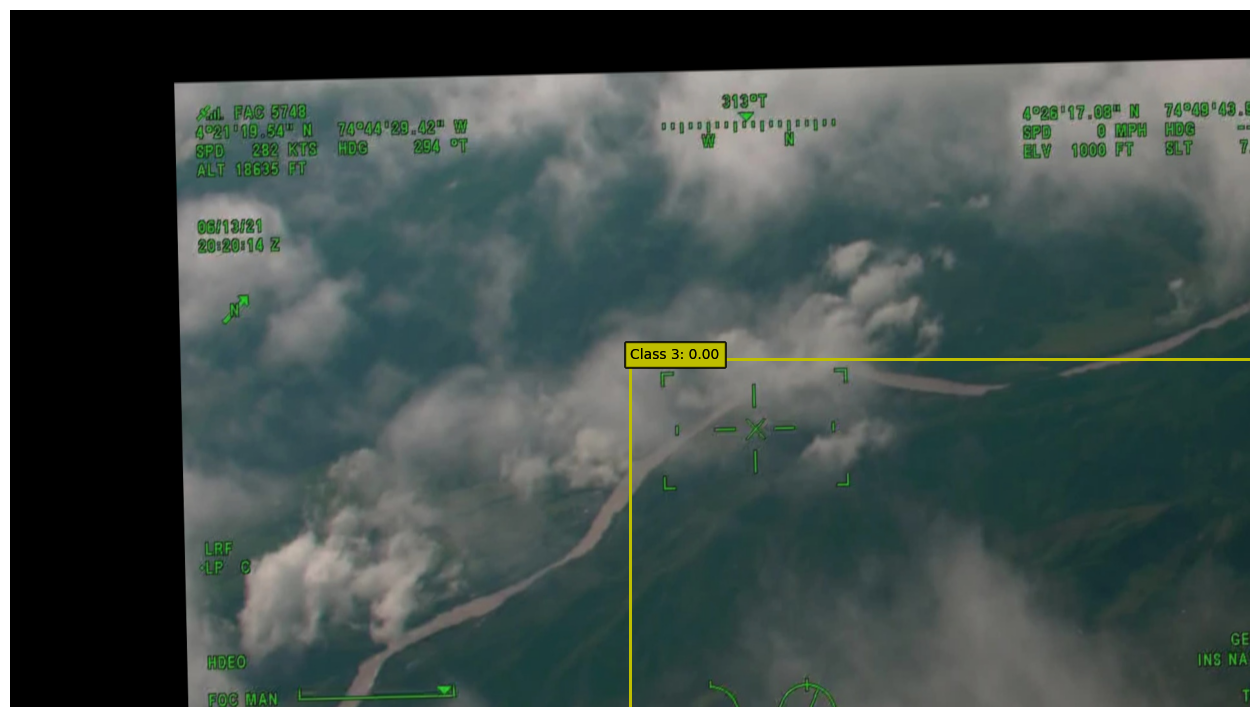

In [18]:
# Ejemplo con una imagen de tu conjunto de prueba
ruta_imagen = "modelo_yolov11_dataset_completo/train/images/aug_class-1_video_11min_002_586_1916.jpg"  # Ajusta esta ruta
resultados = probar_modelo_en_imagen(ruta_imagen, threshold=0.001)